## Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [247]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil
import zipfile
from glob import glob
tf.get_logger().setLevel('ERROR')

In [248]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [295]:
USE_GDRIVE=False
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    USE_GDRIVE=True
    print("Running on Google Colab")
except:
    print("Running on Local PC")    
    

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Running on Google Colab


In [250]:
if USE_GDRIVE == True:
    root_dir="/content/"
    archive_dir="/content/gdrive/MyDrive/"
    dataset_dir=root_dir+"Skin cancer ISIC The International Skin Imaging Collaboration/"
else :
    root_dir="./"
    archive_dir=root_dir
    dataset_dir=root_dir+"Skin cancer ISIC The International Skin Imaging Collaboration/"

In [251]:

try :
    if USE_GDRIVE == False:
        shutil.rmtree('dataset')
    else :
        shutil.rmtree('/content/Skin cancer ISIC The International Skin Imaging Collaboration/')
except:
    print("Data directory not found")

with zipfile.ZipFile(archive_dir+"CNN_assignment.zip", 'r') as zip_ref:
    print("extracting data")
    zip_ref.extractall(".")
    


extracting data


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [252]:
##remove space from name for augmentor
if USE_GDRIVE == False:
    dataset_dir_updated=root_dir+"dataset/"
    os.rename(dataset_dir,dataset_dir_updated)
else :
    dataset_dir_updated=dataset_dir

In [253]:
dataset_train_path=dataset_dir_updated+"Train"
dataset_test_path=dataset_dir_updated+"Test"

In [254]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(dataset_train_path)
data_dir_test = pathlib.Path(dataset_test_path)
print(data_dir_train)

/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [255]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [256]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [257]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(directory=data_dir_train,
                                                       image_size=(img_height, img_height),
                                                      validation_split=0.2,subset='training',
                                                       label_mode='categorical',
                                                      seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [258]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(directory=data_dir_train,
                                                       image_size=(img_height, img_height),
                                                      validation_split=0.2,subset='validation',
                                                     label_mode='categorical',
                                                      seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [259]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes=len(class_names)
print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data

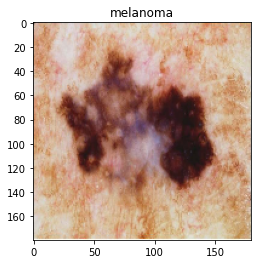

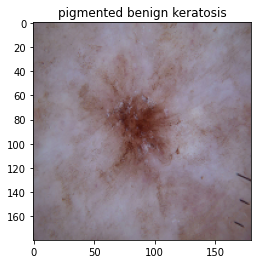

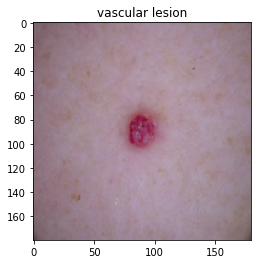

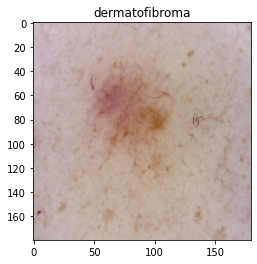

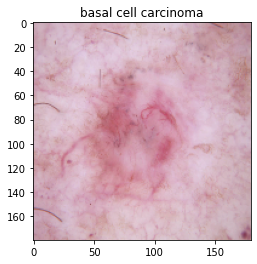

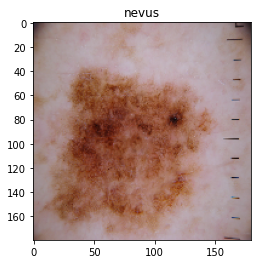

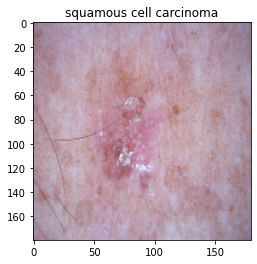

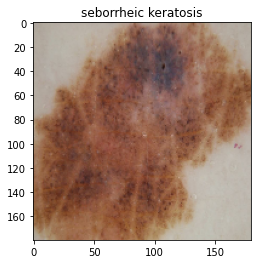

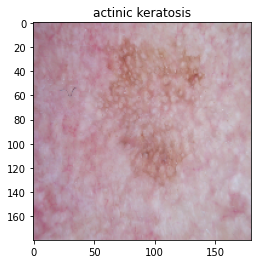

In [260]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
data_iter=iter(val_ds)
s=set()

while len(s)<9:
    d,l=next(data_iter)  
   # print(l.numpy())
    for i in range(0,32):  
        for j in range(0,num_classes):
            t=l[i].numpy()[j]
            if(t==1):
                if j not in s:
                    s.add(j)
                    plt.figure()
                    plt.title(class_names[j])
                    plt.imshow(d[i].numpy().astype(np.uint8))
                    
       
    



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [261]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [262]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import layers

In [263]:
data_rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

In [264]:
### Your code goes here
model = Sequential()
model.add(keras.Input(shape=(img_height, img_width, 3)))
model.add(data_rescale)

model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(512,activation='relu'))

model.add(Dense(len(class_names),activation='softmax'))


In [265]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_95 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_95 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None, 45, 45, 128)     

In [266]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [267]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 95ms/step - loss: 2.1154 - accuracy: 0.1747 - val_loss: 2.2336 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.9560 - accuracy: 0.2606 - val_loss: 1.7877 - val_accuracy: 0.3445
Epoch 3/20
56/56 [==============================] - 3s 49ms/step - loss: 1.7348 - accuracy: 0.3666 - val_loss: 1.6515 - val_accuracy: 0.4206
Epoch 4/20
56/56 [==============================] - 3s 50ms/step - loss: 1.6360 - accuracy: 0.4051 - val_loss: 1.5858 - val_accuracy: 0.4206
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.5191 - accuracy: 0.4632 - val_loss: 1.5067 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4168 - accuracy: 0.5045 - val_loss: 1.4063 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3796 - accuracy: 0.5106 - val_loss: 1.4314 - val_accuracy: 0.4899
Epoch 8/20
5

### Visualizing training results

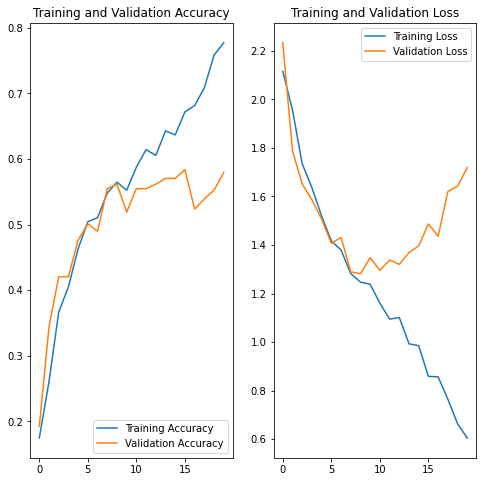

In [268]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The model is overfitting because
   - Validation loss is increasing after few ( 10 ) epochs
   - There is huge gap between training and valiation accuracies

###  Lets add random rotaion and flipping as augmentation strategy

In [269]:


data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical",seed=123),
  layers.RandomRotation(0.2,seed=123),
  layers.RandomZoom(0.2,seed=123)
  
])

### Visualize augmentation

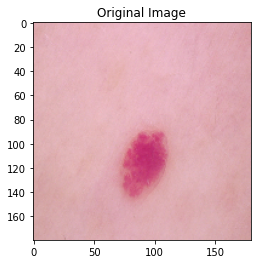

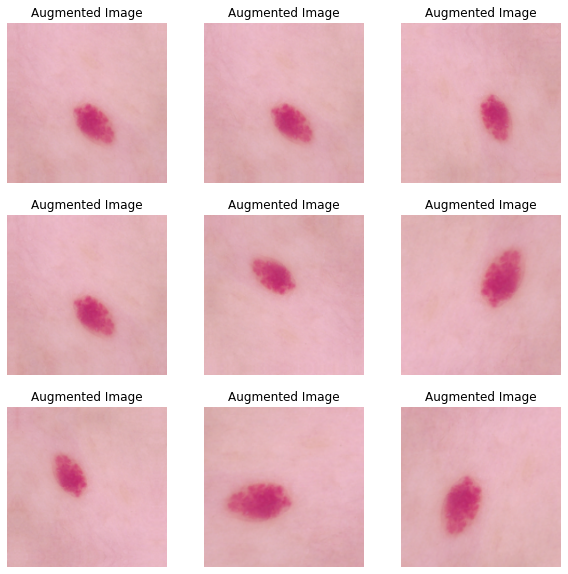

In [270]:
#tf.get_logger().setLevel('ERROR')

for image,label in train_ds.take(1):
    plt.title("Original Image")
    plt.imshow(image[0].numpy().astype(np.uint8))   
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_image = data_augmentation(image,training=True)
        ax = plt.subplot(3, 3, i + 1)  
        plt.title("Augmented Image")
        plt.imshow(augmented_image[0].numpy().astype(np.uint8))
        plt.axis("off")

#### As previous model is also overfitted lets add dropout layer



In [271]:
model_2 = Sequential()
model_2.add(keras.Input(shape=(img_height, img_width, 3)))

model_2.add(data_augmentation)
model_2.add(data_rescale)

model_2.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))


model_2.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))


model_2.add(Flatten())
model_2.add(Dense(512,activation='relu'))
model_2.add(Dropout(0.3))

model_2.add(Dense(len(class_names),activation='softmax'))



### Compiling the model

In [272]:
### Todo, choose an appropirate optimiser and loss function
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_2.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_29 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 sequential_27 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_100 (Conv2D)         (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 90, 90, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_101 (Conv2D)         (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 45, 45, 64)       0         
 ng2D)                                               

### Training the model

In [273]:
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 77ms/step - loss: 2.0661 - accuracy: 0.1908 - val_loss: 1.9401 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 1.9260 - accuracy: 0.2612 - val_loss: 1.8392 - val_accuracy: 0.3154
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.8302 - accuracy: 0.3192 - val_loss: 1.7501 - val_accuracy: 0.3311
Epoch 4/20
56/56 [==============================] - 4s 73ms/step - loss: 1.6557 - accuracy: 0.3834 - val_loss: 1.6193 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 4s 74ms/step - loss: 1.6008 - accuracy: 0.4157 - val_loss: 1.6361 - val_accuracy: 0.4273
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 1.5989 - accuracy: 0.4163 - val_loss: 1.5575 - val_accuracy: 0.4564
Epoch 7/20
56/56 [==============================] - 4s 73ms/step - loss: 1.5866 - accuracy: 0.4325 - val_loss: 1.6074 - val_accuracy: 0.3982
Epoch 8/20
56

### Visualizing the results

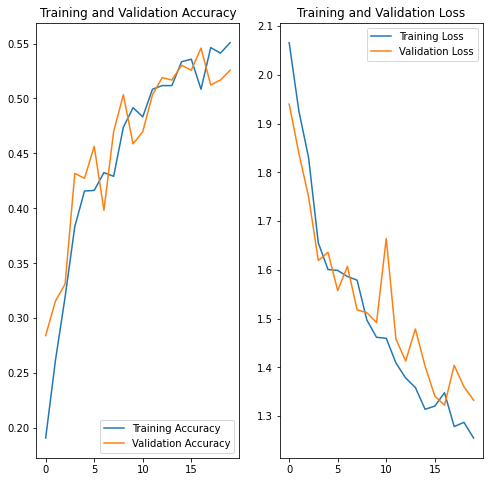

In [274]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings 
- After adding dropout and augementation model is no more overfit. Training accuracy and validation accuracy is closer
- However the model training accuracy dropped a lot. model seems to be overfit
- need to verify data for class imbalance

In [275]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

####  seborrheic keratosis has the list number of samples (77)

#### pigmented benign keratosis domintaes the data in terms of number of samples

### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [276]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [277]:
path_to_training_dataset=dataset_train_path+"/"
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    #p.flip_random(0.5)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)   
    #p.zoom(probability=0.5, min_factor=0.8, max_factor=1.2)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC2784591D0>: 100%|██████████| 500/500 [00:16<00:00, 29.44 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC28CA429D0>: 100%|██████████| 500/500 [00:19<00:00, 25.86 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC28CB10810>: 100%|██████████| 500/500 [00:19<00:00, 25.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC2A2111910>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC30012DA10>: 100%|██████████| 500/500 [01:31<00:00,  5.45 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC278632D10>: 100%|██████████| 500/500 [00:15<00:00, 32.27 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC27C916310>: 100%|██████████| 500/500 [00:40<00:00, 12.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC2785CCBD0>: 100%|██████████| 500/500 [00:15<00:00, 31.81 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC2A4FC8910>: 100%|██████████| 500/500 [00:16<00:00, 30.77 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [278]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [279]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

4500

In [280]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [281]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [282]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
df2

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
4495,/content/Skin cancer ISIC The International Sk...,melanoma
4496,/content/Skin cancer ISIC The International Sk...,melanoma
4497,/content/Skin cancer ISIC The International Sk...,melanoma
4498,/content/Skin cancer ISIC The International Sk...,melanoma


In [283]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [284]:

new_df = original_df.append(df2)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [285]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

### Train the model on the data created using Augmentor

In [286]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [287]:
data_dir_train=dataset_train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [288]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [289]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create  model 

In [290]:
initializer = tf.keras.initializers.HeUniform(seed=123)
model_3 = Sequential()
model_3.add(keras.Input(shape=(img_height, img_width, 3)))

model_3.add(data_augmentation) 
model_3.add(data_rescale)

model_3.add(Conv2D(32, (3, 3), padding='same',activation='relu',kernel_initializer=initializer))
#model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(64, (3, 3), padding='same',activation='relu',kernel_initializer=initializer))
#model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(128, (3, 3), padding='same',activation='relu',kernel_initializer=initializer))
#model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(256, (3, 3), padding='same',activation='relu',kernel_initializer=initializer))
#model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(512, (3, 3), padding='same',activation='relu',kernel_initializer=initializer))
#model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.2))


model_3.add(Flatten())



model_3.add(Dense(512,activation='relu',kernel_initializer=initializer))
model_3.add(Dropout(0.3))

model_3.add(Dense(len(class_names),activation='softmax'))

####  Compile  model 

In [291]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_3.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_29 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 sequential_27 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_105 (Conv2D)         (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 90, 90, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_106 (Conv2D)         (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_106 (MaxPooli  (None, 45, 45, 64)       0         
 ng2D)                                               

In [292]:

epochs = 50
## Your code goes here, use 50 epochs.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[reduce_lr]
)

Epoch 1/50
169/169 [==============================] - 45s 140ms/step - loss: 2.1405 - accuracy: 0.2244 - val_loss: 2.1244 - val_accuracy: 0.2635 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 12s 72ms/step - loss: 1.6360 - accuracy: 0.3709 - val_loss: 1.5673 - val_accuracy: 0.4024 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 13s 78ms/step - loss: 1.5062 - accuracy: 0.4117 - val_loss: 1.4193 - val_accuracy: 0.4365 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 12s 72ms/step - loss: 1.4431 - accuracy: 0.4407 - val_loss: 1.3878 - val_accuracy: 0.4625 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 12s 74ms/step - loss: 1.3930 - accuracy: 0.4468 - val_loss: 1.4106 - val_accuracy: 0.4439 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 12s 72ms/step - loss: 1.3334 - accuracy: 0.4731 - val_loss: 1.2587 - val_accuracy: 0.5063 - lr: 0.0010
Epoch 7/50
169/169 [==============================] - 12s

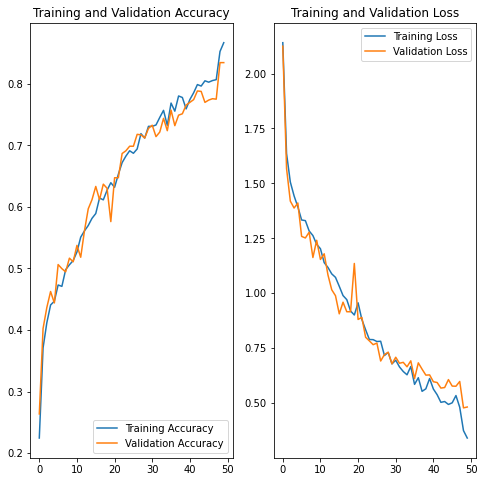

In [293]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Model losss decreased and model accuracy increased
- handling data imbalances help in addressing model underfitting and theryby increasing validation and train accuracy
- Loss is still decreasing . More epoch need to be trained or model need to be prepared for faster convergence

### Check model performance on test data

In [294]:
test_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,image_size=(img_width,img_height),
                                                            shuffle=False,batch_size=120)
predictions=model_3.predict(test_ds)
score = tf.nn.softmax(predictions)
_, labels = tuple(zip(*test_ds))
print()
print(np.argmax(score,axis=-1))
print()

from sklearn.metrics import accuracy_score
print('Test Accuracy')
accuracy_score(labels[0].numpy(),np.argmax(score,axis=-1))

Found 118 files belonging to 9 classes.
1/1 [==============================] - 3s 3s/step

[3 3 4 7 5 7 5 4 0 0 4 0 0 7 0 7 1 7 1 1 0 1 5 3 1 1 5 1 0 1 1 0 3 3 1 3 3
 5 4 1 1 2 2 2 2 1 2 0 4 3 4 4 4 3 3 5 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 4 4 4 4 4 5 5 5 3 5 7 3 5 0 5 5 5 1 5 5 7 3 3 3 4 8 4 3 3 2 7 5 7 5 1 1
 1 5 7 1 8 8 8]

Test Accuracy


0.4576271186440678

### Test accuracy is poor. Need better model and strategy for improving test accuracy